<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Network-reconstuction" data-toc-modified-id="Network-reconstuction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network reconstuction</a></span><ul class="toc-item"><li><span><a href="#Ras-&amp;-WT-panel" data-toc-modified-id="Ras-&amp;-WT-panel-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ras &amp; WT panel</a></span></li><li><span><a href="#BRAF-&amp;-WT" data-toc-modified-id="BRAF-&amp;-WT-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>BRAF &amp; WT</a></span></li><li><span><a href="#EGFR-&amp;-WT" data-toc-modified-id="EGFR-&amp;-WT-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>EGFR &amp; WT</a></span></li></ul></li><li><span><a href="#Generate-graphs" data-toc-modified-id="Generate-graphs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate graphs</a></span><ul class="toc-item"><li><span><a href="#Braf-&amp;-WT-panel" data-toc-modified-id="Braf-&amp;-WT-panel-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Braf &amp; WT panel</a></span></li><li><span><a href="#Ras-&amp;-WT-panel" data-toc-modified-id="Ras-&amp;-WT-panel-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ras &amp; WT panel</a></span></li><li><span><a href="#EGFR-&amp;-WT-panel" data-toc-modified-id="EGFR-&amp;-WT-panel-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>EGFR &amp; WT panel</a></span></li><li><span><a href="#True-topology" data-toc-modified-id="True-topology-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>True topology</a></span></li></ul></li></ul></div>

# Background

In this notebook we prepare the graphs comparing the model reconstructions of the different cell lines. We select sensible hyperparameters based on analyses of their influence on the reconstuction quality.

# Data preparation

Load the required modules/packages.

In [1]:
import os
import sys

import random
import pickle
import pandas as pd
import networkx as nx
import re

import cnr
import cnr.cnrplot
import numpy as np

from mypyutils import utils

import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the results of the simulated perturbations.

In [2]:
# ----------------------------------------------------------------------------
# Inputs

# Interaction map/model topology
f_imap = "results/simulations/imap.tsv"
REF_IMAP = pd.read_csv(f_imap, sep='\t', index_col=0)

# Global response matrices
fSimResults = 'results/simulations/ortonModel-knockdown-mutWT.tsv'
fSimResults_mutRAS = 'results/simulations/ortonModel-knockdown-mutRAS.tsv'
fSimResults_mutBRAF = 'results/simulations/ortonModel-knockdown-mutBRAF.tsv'
fSimResults_mutEGFR = 'results/simulations/ortonModel-knockdown-mutEGFR.tsv'

rglob_wt   = pd.read_csv(fSimResults, sep='\t', index_col=0)
rglob_ras  = pd.read_csv(fSimResults_mutRAS, sep='\t', index_col=0)
rglob_braf = pd.read_csv(fSimResults_mutBRAF, sep='\t', index_col=0)
rglob_egfr = pd.read_csv(fSimResults_mutEGFR, sep='\t', index_col=0)

# Local response matrices
fSimResults_rloc = 'results/simulations/ortonModel-knockdown-mutWT-rloc.tsv'
fSimResults_mutRAS_rloc = 'results/simulations/ortonModel-knockdown-mutRAS-rloc.tsv'
fSimResults_mutBRAF_rloc = 'results/simulations/ortonModel-knockdown-mutBRAF-rloc.tsv'
fSimResults_mutEGFR_rloc = 'results/simulations/ortonModel-knockdown-mutEGFR-rloc.tsv'

rloc_wt   = pd.read_csv(fSimResults_rloc, sep='\t', index_col=0)
rloc_ras  = pd.read_csv(fSimResults_mutRAS_rloc, sep='\t', index_col=0)
rloc_braf = pd.read_csv(fSimResults_mutBRAF_rloc, sep='\t', index_col=0)
rloc_egfr = pd.read_csv(fSimResults_mutEGFR_rloc, sep='\t', index_col=0)

true_rloc_dict = {"wt": rloc_wt, "ras": rloc_ras, "braf": rloc_braf, "egfr": rloc_egfr }

# Perturbation matrices
fSimResults_rpert = 'results/simulations/ortonModel-knockdown-mutWT-rpert.tsv'
fSimResults_mutRAS_rpert = 'results/simulations/ortonModel-knockdown-mutRAS-rpert.tsv'
fSimResults_mutBRAF_rpert = 'results/simulations/ortonModel-knockdown-mutBRAF-rpert.tsv'
fSimResults_mutEGFR_rpert = 'results/simulations/ortonModel-knockdown-mutEGFR-rpert.tsv'

rpert_wt   = pd.read_csv(fSimResults_rpert, sep='\t', index_col=0)
rpert_ras  = pd.read_csv(fSimResults_mutRAS_rpert, sep='\t', index_col=0)
rpert_braf = pd.read_csv(fSimResults_mutBRAF_rpert, sep='\t', index_col=0)
rpert_egfr = pd.read_csv(fSimResults_mutEGFR_rpert, sep='\t', index_col=0)

true_rpert_dict = {"wt": rpert_wt, "ras": rpert_ras, "braf": rpert_braf, "egfr": rpert_egfr}

Cast the simulation is usable format.

Remove spurious information from node names.

In [3]:
def rename_indices(df):
    df.index = [re.sub("Active|bound|eceptor", "", s).upper() for s in df.index]
    df.columns = [re.sub("Active|bound|eceptor", "", s).upper() for s in df.columns]
    df.columns = [s.replace("KNOCKDOWN", " KD").upper() for s in df.columns]

rename_indices(rglob_wt)
rename_indices(rglob_ras)
rename_indices(rglob_braf)
rename_indices(rglob_egfr)
rename_indices(REF_IMAP)

rename_indices(rloc_wt)
rename_indices(rloc_ras)
rename_indices(rloc_braf)
rename_indices(rloc_egfr)


In [4]:
# Round the rglob matrices to prevent numerical instabilities
rglob_wt   = np.round(rglob_wt, 3)
rglob_ras  = np.round(rglob_ras, 3)
rglob_braf = np.round(rglob_braf, 3)
rglob_egfr = np.round(rglob_egfr, 3)

rglob_dict = {
    'wt': rglob_wt, 
    'ras': rglob_ras, 
    'braf':rglob_braf, 
    'egfr': rglob_egfr
}
random.seed(29121982)
rglob_dict_noise = {
    'wt': utils.add_noise(rglob_wt, 0.1), 
    'ras': utils.add_noise(rglob_ras, 0.1),
    'braf':utils.add_noise(rglob_braf, 0.1),
    'egfr': utils.add_noise(rglob_egfr, 0.1)
}


REF_NODES = list(rglob_wt.index)
REF_NODES == list(rglob_wt.index)  == list(rglob_braf.index)

#None of the perturbations is acting downstream.
DOWNSTREAM_ACTING_PERTS = [] 
PERTURBATIONS = [[s] for s in rglob_wt.columns]
INHIBITOR_TARGETS = {x:x.replace(' KD', "") for x in rglob_wt.columns}

Plot the input data

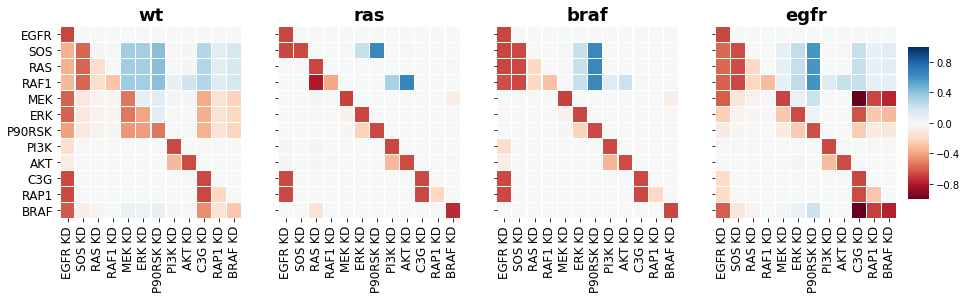

In [5]:
cnr.cnrplot.heatmap_cnr(rglob_dict)

# Network reconstuction

Generate the PerturbationPanel objects

In [6]:
panel_all = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], rglob_dict
)

# Without noise

# Panels with mutant + wt
panel_ras_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], 
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'ras'}} 
)

panel_braf_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'braf'}} 
)
panel_egfr_wt = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict.items() if key in {'wt', 'egfr'}} 
)

panel_all = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], rglob_dict
)

# With noise

# Panels with mutant + wt
panel_ras_wt_noise = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [], 
    {key: val for key, val in rglob_dict_noise.items() if key in {'wt', 'ras'}} 
)

panel_braf_wt_noise = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict_noise.items() if key in {'wt', 'braf'}} 
)
panel_egfr_wt_noise = cnr.PerturbationPanel(
    REF_NODES, PERTURBATIONS, INHIBITOR_TARGETS, [],
    {key: val for key, val in rglob_dict_noise.items() if key in {'wt', 'egfr'}} 
)

Set the relevant parameter values and helper functions.

In [7]:
THETA = 0.01
ETA = 0.005


def tpr(imap, ref_imap):
    tp = ((imap == 1) & (ref_imap == 1)).sum().sum()
    p = ref_imap.sum().sum()
    return(tp/p)

def fpr(imap, ref_imap):
    fp = ((imap == 1) & (ref_imap == 0)).sum().sum()
    n = (ref_imap == 0).sum().sum() - REF_IMAP.shape[0] # Subtract diagonal from # of negatives
    return(fp/n)


def get_param_df(sol, true_rpert_dict, true_rloc_dict):
    df_lst = []
    for cl in sol.cell_lines:
        
        # Get rloc and add to list    
        rl = np.array(sol.rloc[cl]) + np.identity(12)
        nz_rloc = np.nonzero(rl)
        # Select the corresponding true parameters 
        trl = np.array(true_rloc_dict[cl])[nz_rloc]
        # add df to list
        df_lst.append(
            pd.DataFrame({
                "cl": cl, "param": "rloc",
                "cnr": rl[nz_rloc],"true": trl}
            )
        )

        # Select non-zero reconstructed parameters (rloc and rpert)
        rp = np.array(sol.rpert[cl])
        nz_pert = np.nonzero(rp)    
        # Select the corresponding true parameters 
        trp = np.array(true_rpert_dict[cl])[nz_pert]
        df_lst.append(
            pd.DataFrame({
                "cl": cl, "param": "rpert",
                "cnr": rp[nz_pert], "true": trp
            })
        )
    
    return pd.concat(df_lst)


In [8]:
col_dict = dict(zip(
    ["braf_wt", "braf", "ras_wt","ras", "egfr_wt", "egfr"],
    sns.color_palette("Paired")
))
col_dict["wt"] = "#95a5a6"
col_dict["all"] = "#9b59b6"



## Ras & WT panel

In [9]:
p_ras_noise = cnr.CnrProblem(panel_ras_wt_noise, eta=ETA,  theta=THETA)
p_ras_noise.cpx.solve()
sol_ras_noise = cnr.CnrResult(p_ras_noise)

print('\n==================================\n')
print("# of edges: " + str(sol_ras_noise.imap.sum().sum()))
print("# of deviation: " + str(len(sol_ras_noise.deviations_overview().index)))

print("TPR: " + str(tpr(sol_ras_noise.imap, REF_IMAP)))
print("FPR: " + str(fpr(sol_ras_noise.imap, REF_IMAP)))
print("False positives: " + str(((sol_ras_noise.imap - REF_IMAP) == 1).sum().sum()))

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 9.114724 after 0.00 sec. (0.08 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 132 rows and 1 columns.
MIQP Presolve modified 144 coefficients.
Aggregator did 144 substitutions.
Reduced MIQP has 564 rows, 996 columns, and 2757 nonzeros.
Reduced MIQP has 276 binaries, 0 generals, 0 SOSs, and 552 indicators.
Reduced MIQP objective Q matrix has 288 nonzeros.
Presolve time = 0.01 sec. (1.83 ticks)
Probing time = 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 470 rows and 830 columns.
Reduced MIQP has 94 rows, 166 columns, and 449 nonzeros.
Reduced MIQP has 46 binaries, 0 generals, 0 SOSs, and 92 indicators.
Reduced MIQP objective Q matrix has 48 nonzeros.
Presolve time = 0.01 sec. (0.68 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIQP has 94 rows, 166 columns, and 449 nonzeros.
Reduced MIQP has 46 binaries, 0 generals, 0 SOSs, and 92 indicators.


In [10]:
sol_ras_noise.deviations_overview()

,wt,ras,mean
r_BRAF_RAP1,0.972098,0.000162593,0.48613
r_ERK_MEK,1.12246,0.0670929,0.594778
r_MEK_BRAF,0.801903,0.0910664,0.446485
r_P90RSK_ERK,0.792871,0.418862,0.605866
r_RAF1_AKT,-0.349364,-0.952226,-0.650795
r_RAS_SOS,0.935609,-0.000505641,0.467552
rp_BRAF KD_BRAF,-0.320817,-0.81815,-0.569484
rp_MEK KD_MEK,-0.520995,-0.735937,-0.628466
rp_RAS KD_RAS,-0.216297,-0.665402,-0.440849


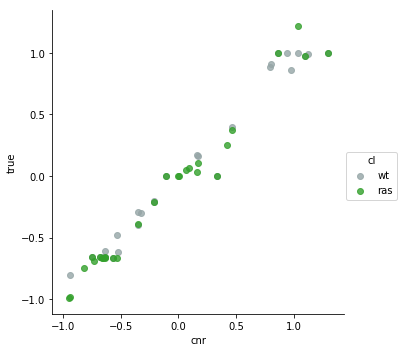

In [11]:
df = get_param_df(sol_ras_noise, true_rpert_dict, true_rloc_dict)
sns.lmplot(x="cnr", y="true", data=df, hue="cl", fit_reg=False, 
           palette=col_dict);

## BRAF & WT

In [12]:
p_braf_noise = cnr.CnrProblem(panel_braf_wt_noise, eta=ETA,  theta=THETA)
p_braf_noise.cpx.solve()
sol_braf_noise = cnr.CnrResult(p_braf_noise)

print('\n==================================\n')
print("# of edges: " + str(sol_braf_noise.imap.sum().sum()))
print("# of deviation: " + str(len(sol_braf_noise.deviations_overview().index)))

print("TPR: " + str(tpr(sol_braf_noise.imap, REF_IMAP)))
print("FPR: " + str(fpr(sol_braf_noise.imap, REF_IMAP)))
print("False positives: " + str(((sol_braf_noise.imap - REF_IMAP) == 1).sum().sum()))

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 9.754806 after 0.00 sec. (0.07 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 132 rows and 1 columns.
MIQP Presolve modified 144 coefficients.
Aggregator did 144 substitutions.
Reduced MIQP has 564 rows, 996 columns, and 2603 nonzeros.
Reduced MIQP has 276 binaries, 0 generals, 0 SOSs, and 552 indicators.
Reduced MIQP objective Q matrix has 288 nonzeros.
Presolve time = 0.01 sec. (1.81 ticks)
Probing time = 0.01 sec. (0.18 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 470 rows and 830 columns.
Reduced MIQP has 94 rows, 166 columns, and 447 nonzeros.
Reduced MIQP has 46 binaries, 0 generals, 0 SOSs, and 92 indicators.
Reduced MIQP objective Q matrix has 48 nonzeros.
Presolve time = 0.02 sec. (0.67 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIQP has 94 rows, 166 columns, and 447 nonzeros.
Reduced MIQP has 46 binaries, 0 generals, 0 SOSs, and 92 indicators.


In [13]:
sol_braf_noise.deviations_overview()

,wt,braf,mean
r_BRAF_RAP1,0.972159,-0.0344583,0.46885
r_ERK_MEK,1.12478,0.0738022,0.599292
r_MEK_BRAF,0.807248,0.0779526,0.4426
r_P90RSK_ERK,0.795351,0.345694,0.570523
rp_BRAF KD_BRAF,-0.303702,-0.803823,-0.553763


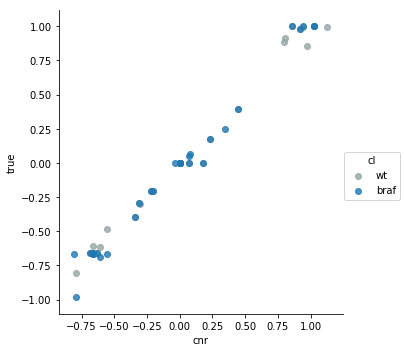

In [14]:
df = get_param_df(sol_braf_noise, true_rpert_dict, true_rloc_dict)
sns.lmplot(x="cnr", y="true", data=df, hue="cl", fit_reg=False, 
           palette=col_dict);

## EGFR & WT 

In [16]:
p_egfr_noise = cnr.CnrProblem(panel_egfr_wt_noise, eta=ETA,  theta=THETA)
p_egfr_noise.cpx.solve()
sol_egfr_noise = cnr.CnrResult(p_egfr_noise)

print('\n==================================\n')
print("# of edges: " + str(sol_egfr_noise.imap.sum().sum()))
print("# of deviation: " + str(len(sol_egfr_noise.deviations_overview().index)))

print("TPR: " + str(tpr(sol_egfr_noise.imap, REF_IMAP)))
print("FPR: " + str(fpr(sol_egfr_noise.imap, REF_IMAP)))
print("False positives: " + str(((sol_egfr_noise.imap - REF_IMAP) == 1).sum().sum()))

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 12.232954 after 0.00 sec. (0.08 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 132 rows and 1 columns.
MIQP Presolve modified 144 coefficients.
Aggregator did 144 substitutions.
Reduced MIQP has 564 rows, 996 columns, and 3164 nonzeros.
Reduced MIQP has 276 binaries, 0 generals, 0 SOSs, and 552 indicators.
Reduced MIQP objective Q matrix has 288 nonzeros.
Presolve time = 0.01 sec. (1.91 ticks)
Probing time = 0.00 sec. (0.20 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 376 rows and 664 columns.
Reduced MIQP has 188 rows, 332 columns, and 1054 nonzeros.
Reduced MIQP has 92 binaries, 0 generals, 0 SOSs, and 184 indicators.
Reduced MIQP objective Q matrix has 96 nonzeros.
Presolve time = 0.02 sec. (0.75 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Reduced MIQP has 188 rows, 332 columns, and 1054 nonzeros.
Reduced MIQP has 92 binaries, 0 generals, 0 SOSs, and 184 indic

In [17]:
sol_egfr_noise.deviations_overview()

,wt,egfr,mean
r_BRAF_RAP1,0.970129,2.10487,1.5375
r_C3G_EGFR,1.04773,0.293803,0.670767
r_ERK_C3G,0.00617012,0.44202,0.224095
r_ERK_MEK,1.12154,0.362921,0.742232
r_MEK_RAP1,-0.0546843,0.439761,0.192538
r_P90RSK_ERK,0.790962,0.38762,0.589291
rp_BRAF KD_BRAF,-0.33046,-0.792258,-0.561359
rp_MEK KD_MEK,-0.523802,-0.75276,-0.638281


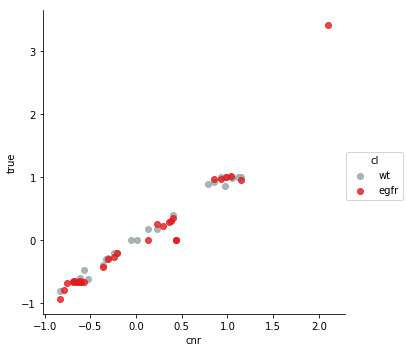

In [18]:
df = get_param_df(sol_egfr_noise, true_rpert_dict, true_rloc_dict)
sns.lmplot(x="cnr", y="true", data=df, hue="cl", fit_reg=False, 
           palette=col_dict);

# Generate graphs

Define the helper functions and parameters.

In [19]:
graph_pos = {
    'EGFR': (0, 0),
    'SOS': (0., -1),
    'RAS': (0., -2),
    'RAF1': (0, -3),
    'MEK': (0, -4),
    'ERK': (0, -5),
    'P90RSK': (-1, -5),
    'PI3K': (-1, -2),
    'AKT': (-1, -3),
    'C3G': (1, -1),
    'RAP1': (1, -2),
    'BRAF': (1, -3),
    
    'ERK KD': (0.75, -4.5),
    'RAS KD': (0.75, -1.5),
    'BRAF KD': (1.75, -2.5),
    'MEK KD': (0.75, -3.5)
}


In [20]:
def remove_edges(G, weigth_cutoff = 0.0):
    edges_to_remove = []
    for i, j, weight in G.edges(data="weight"):
        if abs(weight) < weigth_cutoff:
            edges_to_remove.append((i, j))
    G.remove_edges_from(edges_to_remove)


def write_orton_gml(G, graph_pos, fname, nodes_drop=None, weigth_cutoff = 0.0, highlight_diff = True):

    pos_x = dict()
    pos_y = dict()
    for key, val in graph_pos.items():
        pos_x[key] = int(35*val[0])
        pos_y[key] = int(-30*val[1])

    nx.set_node_attributes(G, pos_x, 'x')
    nx.set_node_attributes(G, pos_y, 'y')
    
    remove_edges(G, weigth_cutoff)      
    
    if nodes_drop:
        G.remove_nodes_from(nodes_drop)
    
    # Make feedback edge curved
    d = {key: 0 for key in G.edges()}
    d[("P90RSK", "SOS")] = 1
    nx.set_edge_attributes(G, d, "curved")
        
    if highlight_diff:
        for parent, child in G.edges():
            if G[parent][child]['deviation'] == 0.:
                G[parent][child]['color'] = 'light-gray'
    nx.write_gml(G, fname)



## Braf & WT panel

In [21]:
g_braf_noise = cnr.cnrplot.graph_from_sol(sol_braf_noise, "braf", 4)
g_wt_noise = cnr.cnrplot.graph_from_sol(sol_braf_noise, "wt", 4)

perturbation_nodes = set(utils.flatten_list(sol_braf_noise.perts))
deviations = [i.split("_")[1] for i in sol_braf_noise.deviations_overview().index]
nodes_drop = (perturbation_nodes - set(deviations))

write_orton_gml(
    g_wt_noise, graph_pos,
    "results/graphs/panel-braf-wt-noise_wt.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)

write_orton_gml(
    g_braf_noise, graph_pos,
    "results/graphs/panel-braf-wt-noise_braf.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)

## Ras & WT panel 

In [22]:
g_ras_noise = cnr.cnrplot.graph_from_sol(sol_ras_noise, "ras", 4)
g_wt_noise = cnr.cnrplot.graph_from_sol(sol_ras_noise, "wt", 4)

perturbation_nodes = set(utils.flatten_list(sol_ras_noise.perts))
deviations = [i.split("_")[1] for i in sol_ras_noise.deviations_overview().index]
nodes_drop = (perturbation_nodes - set(deviations))

write_orton_gml(
    g_wt_noise, graph_pos,
    "results/graphs/panel-ras-wt-noise_wt.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)

write_orton_gml(
    g_ras_noise, graph_pos,
    "results/graphs/panel-ras-wt-noise_ras.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)


## EGFR & WT panel

In [23]:
g_egfr_noise = cnr.cnrplot.graph_from_sol(sol_egfr_noise, "egfr", 4)
g_wt_noise = cnr.cnrplot.graph_from_sol(sol_egfr_noise, "wt", 4)

perturbation_nodes = set(utils.flatten_list(sol_egfr_noise.perts))
deviations = [i.split("_")[1] for i in sol_egfr_noise.deviations_overview().index]
nodes_drop = (perturbation_nodes - set(deviations))

write_orton_gml(
    g_wt_noise, graph_pos,
    "results/graphs/panel-egfr-wt-noise_wt.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)

write_orton_gml(
    g_egfr_noise, graph_pos,
    "results/graphs/panel-egfr-wt-noise_egfr.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.05
)


## True topology

In [24]:
%%capture
i = REF_IMAP.columns[np.array(REF_IMAP).nonzero()[0]]
j = REF_IMAP.columns[np.array(REF_IMAP).nonzero()[1]]
real_interactions = list(zip(i, j))

p = cnr.CnrProblem(panel_all, prior_network = real_interactions, maxdevs=0)
p.cpx.solve()
sol = cnr.CnrResult(p)


In [25]:
import mypyutils
g = cnr.cnrplot.graph_from_sol(sol, "egfr", 0)
perturbation_nodes = set(utils.flatten_list(sol.perts))
nodes_drop = perturbation_nodes


write_orton_gml(
    g, graph_pos,
    "results/graphs/panel-true-topology.gml",
    nodes_drop=nodes_drop,
    weigth_cutoff = 0.0
)
